 ### 一.高维高斯函数
 
 到了结合前两节内容并编码实现的环节了，由于实际处理数据往往不是一维数据，所以需要将概率密度函数扩展到高维的情况，定义如下：   
 
 $$
 N(x\mid u,\Sigma)=\frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}}exp[-\frac{1}{2}(x-u)^T\Sigma^{-1}(x-u)]
 $$
 
 这里$u$表示均值，$\Sigma$表示协方差矩阵，$|\Sigma|$表示协方差矩阵的行列式，$d$表示$x$的维度，即$x\in R^d$，类比第一节，直接写出它的对数似然函数：   
 
 $$
 L(u,\Sigma)=log(\prod_{i=1}^MN(x_i\mid u,\Sigma))=-\frac{Md}{2}log2\pi-\frac{M}{2}log|\Sigma|-\frac{1}{2}\sum_{i=1}^M(x_i-u)^T\Sigma^{-1}(x_i-u)
 $$   
 
 求最优解的思路也一样，对$u,\Sigma$求偏导并令其为0即可：  


 
 $$
 \frac{\partial L(u,\Sigma)}{\partial u}=\Sigma^{-1}(\sum_{i=1}^M(x_i-u))=0\Rightarrow\sum_{i=1}^M(x_i-u)=0\Rightarrow u^*=\frac{\sum_{i=1}^Mx_i}{M}
 $$  
 
 $$
  \frac{\partial L(u,\Sigma)}{\partial \Sigma}=-\frac{M}{2}\frac{1}{|\Sigma|}|\Sigma|\Sigma^{-1}+\frac{1}{2}\Sigma^{-1}\sum_{i=1}^M[(x_i-u)(x_i-u)^T]\Sigma^{-1}=0\Rightarrow \Sigma=\frac{\sum_{i=1}^M[(x_i-u^*)(x_i-u^*)^T]}{M}
 $$
 
 #### 补充一下上面要用到的求导公式
 （1）$f(x)=x^TAx\Rightarrow \frac{\partial f(x)}{\partial x}=Ax+A^Tx$；  
 
 （2）$f(A)=|A|\Rightarrow \frac{\partial f(A)}{\partial A}=|A|(A^{-1})^T$；  
 
 （3）$f(A)=x^TAy\Rightarrow \frac{\partial f(A)}{\partial A}=xy^T$；  
 
 （4）$f(A)=A^{-1}\Rightarrow \frac{\partial f(A)}{\partial A_{i,j}}=-A^{-1}\frac{\partial A}{\partial A_{i,j}}A^{-1}$；   
 
 由（3），（4）可推得（注意，下面的$\Sigma$为对称阵）：   
 
 （5）$f(\Sigma)=x^T\Sigma^{-1}x\Rightarrow \frac{\partial f(\Sigma)}{\partial \Sigma_{i,j}}=-x^T\Sigma^{-1}\frac{\partial \Sigma}{\partial \Sigma_{i,j}}\Sigma^{-1}x$，由于$\frac{\partial \Sigma}{\partial \Sigma_{i,j}}$仅在位置$(i,j)$处为1，其余地方为0，所以$\frac{\partial f(\Sigma)}{\partial \Sigma}=-\Sigma^{-1}xx^T\Sigma^{-1}$

接下来造一些数据看看效果

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data=np.vstack((np.random.random(size=(50,2))*0.3+[0.3,0.4],np.random.random(size=(50,2))*1.5))

In [2]:
u=np.mean(data,axis=0)
sigma=np.cov(data.T)

In [3]:
#定义高维高斯函数
def gaussian_nd(x,u,sigma):
    return 1.0/(np.power(2*np.pi,x.shape[1]/2)*np.sqrt(np.linalg.det(sigma)))*np.exp(np.sum(-0.5*(x-u).dot(np.linalg.inv(sigma))*(x-u),axis=1))

In [4]:
#封装到utils中
def plot_contourf(data,func,lines=3):
    n = 256
    x = np.linspace(data[:,0].min(), data[:,0].max(), n)
    y = np.linspace(data[:,1].min(), data[:,1].max(), n)
    X, Y = np.meshgrid(x,y)
    C = plt.contour(X,Y, func(np.c_[X.reshape(-1),Y.reshape(-1)]).reshape(X.shape), lines, colors='g', linewidth=0.5)
    plt.clabel(C, inline=True, fontsize=10)
    plt.scatter(data[:,0],data[:,1])

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


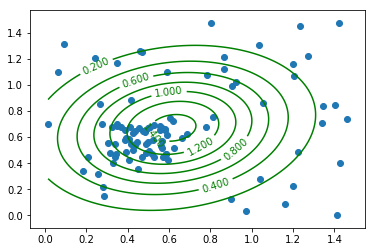

In [5]:
#画高斯图的等高线
plot_contourf(data,lambda x:gaussian_nd(x,u,sigma),8)

### 二.高斯混合模型
高斯混合模型模型定义与第一节类似，可以定义如下：   

$$
P(X\mid\theta)=\sum_{k=1}^K\alpha_k N(X\mid u_k,\Sigma_k)\\
\alpha_k\geq 0,\sum_{k=1}^K\alpha_k=1\\
\theta=\{\alpha_1,\alpha_2,...,\alpha_K,u_1,u_2,...,u_K,\Sigma_1,\Sigma_2,...,\Sigma_K\}
$$  


这里$K$表示高斯混合模型中高斯模型的数量，$\alpha_k$表示第$k$个高斯模型的权重，由于有$\sum_{k=1}^K\alpha_k=1$的约束，所以$\theta$的自由度还可以少1，比如去掉$\alpha_K$，类似于第一节，我们可以人为的求一组高斯混合模型...

In [6]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=4,cluster_std=0.85, random_state=0)
X = X[:, ::-1]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


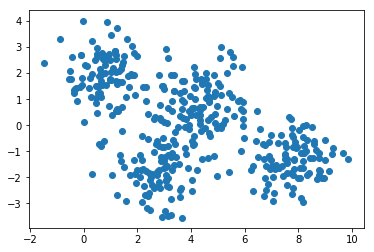

In [7]:
plt.scatter(X[:,0],X[:,1])

In [8]:
theta=[]
for i in range(0,4):
    theta.append((np.mean(X[y==i],axis=0),np.cov(X[y==i].T)))

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


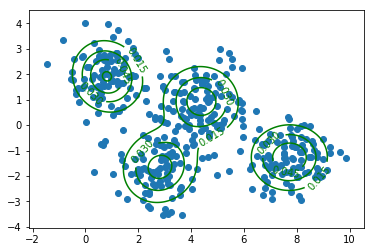

In [9]:
plot_contourf(X,lambda x:np.sum([0.25*gaussian_nd(x,u,sigma) for u,sigma in theta],axis=0),lines=5)

### 三.EM求解GMM模型
上面人工演示了我们想要的结果，接下来实际用EM算法进行求解，而EM求解就是一个极大化$Q$函数的过程：   

$$
Q(\theta,\theta^j)=\sum_{Z}logP(X,Z\mid\theta)P(Z\mid X,\theta^j)
$$

所以根据$Q$函数，我们自然需要确认3个量：      

（1）隐变量$Z$是什么？    

（2）完全数据的对数似然函数$logP(X,Z\mid\theta)$如何求解？   

（3）隐变量在第$j$步的概率分布如何求解$P(Z\mid X,\theta^j)$？

#### 3.1 隐变量$Z$的确定
我们可以设想观测数据$X_i,i=1,2,...,M$是这样产生的，首先按照概率$\alpha_k(k=1,2,...,K)$选择第$k$个高斯分布分模型$N(X\mid u_k,\Sigma_k)$，然后依第$k$个分模型的概率分布$N(X\mid u_k,\Sigma_k)$生成观测数据$X_i$，由于$X_i$已知（已经被选出），那么$Z$可以表示这个做抉择的过程：   

$$
Z_{i,k}=\left\{\begin{matrix}
1 & 第i个观测来自第k个分模型\\ 
0 & 否则
\end{matrix}\right.,i=1,2,...,M,k=1,2,...,K
$$

#### 3.2 完全数据的对数似然函数$logP(X,Z\mid \theta)$
那么，对于$Z_{i,k}=1$，即第$i$个观测来源于第$k$个分模型的概率：   
$$
P(X_i,Z_{i,k}\mid \theta)=\alpha_kN(X_i\mid u_k,\Sigma_k)
$$  

所以：  

$$
logP(X_i,Z_{i,k}=1\mid \theta)=log\alpha_k-\frac{d}{2}log2\pi-\frac{1}{2}log|\Sigma_k|-\frac{1}{2}(x_i-u_k)^T\Sigma_k^{-1}(x_i-u_k)
$$

#### 3.3 隐变量的概率分布$P(Z\mid X,\theta^j)$
在第$j$轮如何求解$Z$的概率分布呢，它的求解可以写作如下：   

$$
P(Z_{i,k}=1\mid X_i,\theta^j)=\frac{\alpha_k^jN(X_i\mid u_k^j,\Sigma_k^j)}{\sum_{l=1}^K\alpha_l^jN(X_i\mid u_l^j,\Sigma_l^j)}=w_{i,k}^j
$$  

这里$\alpha_k^j,u_k^j,\Sigma_k^j$表述第$j$步，第$k$个分模型的参数，这一步如何理解呢？如下图是两个一维混合高斯模型，第一个模型（绿色）参数为$\{\alpha_1,u_1,\Sigma_1\}$ ,第二个模型（红色）参数为$\{\alpha_2,u_2,\Sigma_2\}$，它们的组合的概率分布为黄色线条所示，对于某一点$X_i$,它对应的$Z$的分布，可以理解为各高斯模型概率密度的占比，比如第一个模型的占比为$\frac{a}{a+b}$ ，即$\frac{\alpha_1N(X_i\mid u_1,\Sigma_1)}{\alpha_1N(X_i\mid u_1,\Sigma_1)+\alpha_2N(X_i\mid u_2,\Sigma_2)}$  
![avatar](./source/11_Z概率分布.png)

#### 极大化Q函数
所以$Q$函数可以表示如下：   

$$
Q(\theta,\theta^j)=-\frac{Md}{2}log2\pi+\sum_{i=1}^M\sum_{k=1}^Kw_{i,k}^j[log\alpha_k-\frac{1}{2}(x_i-u_k)^T\Sigma_k^{-1}(x_i-u_k)-\frac{1}{2}log|\Sigma_k|]\\
s.t. \sum_{k=1}^K\alpha_k=1,\alpha_k\geq0
$$

极大化的过程与之前类似，对$u_k,\Sigma_k$求偏导，并令其为0即可得到$u_k^{j+1},\Sigma_k^{j+1}$：   

$$
u_k^{j+1}=\frac{\sum_{i=1}^Mw_{i,k}^jx_i}{\sum_{i=1}^Mw_{i,k}^j}\\
$$

$$
\Sigma_k^{j+1}=\frac{\sum_{i=1}^Mw_{i,k}^j[(x_i-u_k^j)(x_i-u_k^j)^T]}{\sum_{i=1}^Mw_{i,k}^j}
$$

由于$\alpha_k$有个约束条件，可以通过构造拉格朗日函数来求解，将$\alpha_k$的损失函数单独拎出来并构造其拉格朗日函数：   

$$
L(\alpha_1,\alpha_2,...,\alpha_K,\eta_1,\eta_2,...,\eta_K,\beta)=-\sum_{k=1}^K\sum_{i=1}^Mw_{i,k}^jlog\alpha_k-\sum_{k=1}^K\eta_k\alpha_k+\beta(1-\sum_{k=1}^K\alpha_k)\\
s.t.\eta_k\geq 0,k=1,2,...,K
$$  

求解其KKT条件可得：   

$$
\alpha_k^{j+1}=\frac{\sum_{i=1}^Mw_{i,k}^j}{\sum_{l=1}^K\sum_{i=1}^Mw_{i,l}^j}=\frac{\sum_{i=1}^Mw_{i,k}^j}{M}
$$   

PS：其实拉格朗日函数里面可以不要$\eta_k(k=1,2,...,K)$项，因为$\alpha_k(k=1,2,...,K)$从初始化以及后续更新过程中都有$\alpha_k>0(k=1,2,...,K)$，根据互补松弛条件必然有$\eta_k=0(k=1,2,...,K)$

### 四.代码实现

In [10]:
import os
os.chdir('../')
from ml_models import utils
import numpy as np
%matplotlib inline

"""
代码封装到ml_models.em下
"""

class GMMCluster(object):
    def __init__(self, n_components=1, tol=1e-3, n_iter=100, verbose=False):
        """
        使用EM训练GMM
        :param n_components: 高斯混合模型数量
        :param tol: -log likehold增益<tol时，停止训练
        :param n_iter: 最多迭代次数
        :param verbose: 是否可视化训练过程
        """
        self.n_components = n_components
        self.tol = tol
        self.n_iter = n_iter
        self.verbose = verbose
        # 高斯模型参数
        self.params = []

    def fit(self, X):
        n_sample, _ = X.shape
        # 初始化参数
        u = np.mean(X, axis=0)
        sigma = np.cov(X.T)
        alpha = 1.0 / self.n_components
        max_value = X.max()
        min_value = X.min()
        for _ in range(0, self.n_components):
            # 每个高斯模型的权重初始化一样
            # 每个高斯模型的均值在整体均值的基础上添加一个随机的bias
            # 方差初始化一样，使用整体的方差
            self.params.append([alpha, u + np.random.random() * (max_value + min_value) / 2, sigma])
        # 计算当前的隐变量
        W = np.asarray([utils.gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.params]).T
        W = W / np.sum(W, axis=1, keepdims=True)
        # 记录当前的log like hold
        current_log_loss = np.log(W.sum(axis=1)).sum() / n_sample
        # 迭代训练
        for _ in range(0, self.n_iter):
            if self.verbose is True:
                utils.plot_contourf(X, lambda x: np.sum(
                    [alpha * utils.gaussian_nd(x, u, sigma) for alpha, u, sigma in self.params], axis=0), lines=5)
                utils.plt.pause(0.1)
                utils.plt.clf()
            # 更新高斯模型参数
            for k in range(0, self.n_components):
                self.params[k][0] = W[:, k].sum() / n_sample  # 更新alpha
                self.params[k][1] = np.sum(W[:, [k]] * X, axis=0) / W[:, k].sum()  # 更新均值
                self.params[k][2] = np.sum(
                    [W[i, k] * (X[[i]] - self.params[k][1]).T.dot(X[[i]] - self.params[k][1]) for i in
                     range(0, n_sample)], axis=0) / W[:, k].sum()  # 更新方差
            # 更新当前的隐变量
            W = np.asarray([utils.gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.params]).T
            W = W / np.sum(W, axis=1, keepdims=True)
            # 计算log like hold
            new_log_loss = np.log(W.sum(axis=1)).sum() / n_sample
            if np.abs(new_log_loss - current_log_loss) > np.log(self.tol):
                current_log_loss = new_log_loss
            else:
                break
        if self.verbose:
            utils.plot_contourf(X, lambda x: np.sum(
                [alpha * utils.gaussian_nd(x, u, sigma) for alpha, u, sigma in self.params], axis=0), lines=5)
            utils.plt.show()

    def predict_proba(self, X):
        # 预测样本在几个高斯模型上的概率分布
        W = np.asarray([utils.gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.params]).T
        W = W / np.sum(W, axis=1, keepdims=True)
        return W

    def predict(self, X):
        # 预测样本最有可能产生于那一个高斯模型
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_sample_generate_proba(self, X):
        # 返回样本的生成概率
        W = np.asarray([utils.gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.params]).T
        return np.sum(W, axis=1)

In [11]:
#训练模型
#verbose=True，显示训练过程：请在pycharm中使用，notebook会产生多张图片
gmm = GMMCluster(verbose=False,n_iter=200,n_components=4,tol=1e-5)
gmm.fit(X)

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


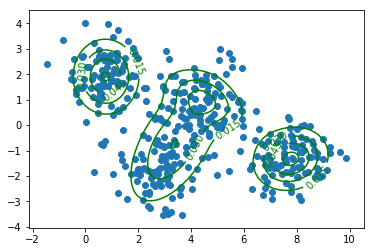

In [12]:
#查看概率分布：可以看到效果与我们人工生成的差不多
utils.plot_contourf(X,gmm.predict_sample_generate_proba,lines=5)

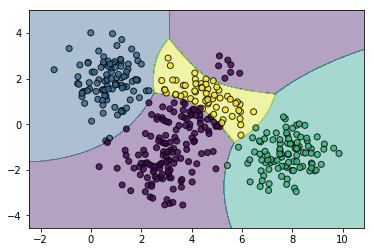

In [13]:
#查看分类边界
utils.plot_decision_function(X,gmm.predict(X),gmm)

显然利用EM进行的无监督训练的GMM可以用于聚类任务，另外GMM用于分类也是可以的，思路同上面第二点一样，只是无需用到EM算法，下一节简单实现一下并作一定的扩展